### Sử dụng model Random forest và dự đoán trên tập test

In [77]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

#### 1. Bước chuẩn bị dữ liệu

In [78]:
with open("final_model_clustered/preprocessor.pkl", "rb") as file:
    preprocessor = pickle.load(file)

In [79]:
preprocessor.feature_names_in_

array(['venue', 'season', 'win_percent_diff', 'draw_percent_before_team2',
       'draw_percent_diff', 'lose_percent_before_team1',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent',
       'is_opponent_big6', 'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2'], dtype=object)

In [80]:
with open("final_model_clustered/preprocessor_clustering.pkl", "rb") as file:
    preprocessor_clustering = pickle.load(file)

In [81]:
preprocessor_clustering.feature_names_in_

array(['Cluster', 'match_type'], dtype=object)

In [82]:
with open("final_model_clustered/RF.pkl", "rb") as file:
    RF_model = pickle.load(file)

In [83]:
with open("final_model_clustered/kmeans_model.pkl", "rb") as file:
    kmeans_model = pickle.load(file)

In [84]:
# Định nghĩa các hàm gán nhãn
def assign_cluster_label(cluster):
    if cluster == 1:
        return 'Weak Opponent'
    elif cluster == 0:
        return 'Average Opponent'
    elif cluster == 2:
        return 'Strong Opponent'
    else:
        return 'Unknown'

def assign_win_label(cluster):
    if cluster == 1:
        return 'Diverse Win Rate'
    elif cluster == 0:
        return 'Low Win Rate'
    elif cluster == 2:
        return 'High Win Rate'
    else:
        return 'Unknown'

In [85]:
# Load dữ liệu từ tập test
test_df = pd.read_csv("../../../feature_engineering_data/test/manchester_united.csv")
test_df["win_percent_diff"] = test_df['win_percent_before_team1'] - test_df['win_percent_before_team2']
test_df["draw_percent_diff"] = test_df['draw_percent_before_team1'] - test_df['draw_percent_before_team2']
test_df["ELO_before_diff"] = test_df['ELO_before_match_team1'] - test_df['ELO_before_match_team2']

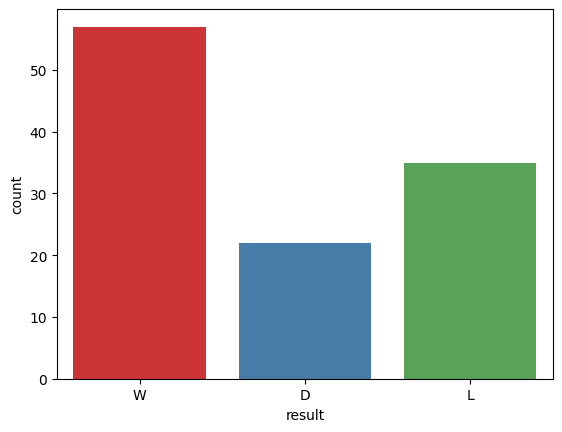

In [86]:
sns.countplot(x="result", data=test_df, palette="Set1");

In [87]:
test_df_with_opponent = test_df[
    [
        "opponent",
        'result',
        'venue',
        'season', 
        'win_percent_diff',
        'draw_percent_before_team2',  
        'draw_percent_diff',
        'lose_percent_before_team1', 
        'lose_percent_before_team2',
        'head2head_win_percent', 
        'head2head_draw_percent',
        'head2head_lost_percent', 
        'is_opponent_big6', 
        'ELO_before_match_team2',
        'ELO_before_diff', 
        'average_score_before_match_team2',
    ]
]

test_df = test_df[
    [
        'result',
        'venue',
        'season', 
        'win_percent_diff',
        'draw_percent_before_team2',  
        'draw_percent_diff',
        'lose_percent_before_team1', 
        'lose_percent_before_team2',
        'head2head_win_percent', 
        'head2head_draw_percent',
        'head2head_lost_percent', 
        'is_opponent_big6', 
        'ELO_before_match_team2',
        'ELO_before_diff', 
        'average_score_before_match_team2',
    ]
]

In [88]:
test_df.head()

,result,venue,season,win_percent_diff,draw_percent_before_team2,draw_percent_diff,lose_percent_before_team1,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,W,Home,2021-2022,0.000000,0.000000,0.00,0.0,0.000000,0.5,0.5,0.0,0,1500.000000,0.000000,0.000000
1,D,Away,2021-2022,1.000000,0.000000,0.00,0.0,1.000000,0.5,0.5,0.0,0,1462.500000,84.375000,0.000000
2,W,Away,2021-2022,0.500000,0.000000,0.50,0.0,1.000000,0.5,0.3,0.2,0,1443.061682,109.767983,0.000000
3,W,Home,2021-2022,0.666667,0.333333,0.00,0.0,0.666667,0.6,0.2,0.2,0,1427.483871,166.152954,0.333333
4,W,Away,2021-2022,0.250000,0.500000,-0.25,0.0,0.000000,0.5,0.3,0.2,0,1579.299852,38.625999,2.000000


In [89]:
test_df.columns

Index(['result', 'venue', 'season', 'win_percent_diff',
       'draw_percent_before_team2', 'draw_percent_diff',
       'lose_percent_before_team1', 'lose_percent_before_team2',
       'head2head_win_percent', 'head2head_draw_percent',
       'head2head_lost_percent', 'is_opponent_big6', 'ELO_before_match_team2',
       'ELO_before_diff', 'average_score_before_match_team2'],
      dtype='object')

##### Phân chia dữ liệu thành X, y

In [90]:
X_test = test_df.drop(["result"], axis=1)
y_test = test_df["result"]

In [91]:
X_test.head()

,venue,season,win_percent_diff,draw_percent_before_team2,draw_percent_diff,lose_percent_before_team1,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,Home,2021-2022,0.000000,0.000000,0.00,0.0,0.000000,0.5,0.5,0.0,0,1500.000000,0.000000,0.000000
1,Away,2021-2022,1.000000,0.000000,0.00,0.0,1.000000,0.5,0.5,0.0,0,1462.500000,84.375000,0.000000
2,Away,2021-2022,0.500000,0.000000,0.50,0.0,1.000000,0.5,0.3,0.2,0,1443.061682,109.767983,0.000000
3,Home,2021-2022,0.666667,0.333333,0.00,0.0,0.666667,0.6,0.2,0.2,0,1427.483871,166.152954,0.333333
4,Away,2021-2022,0.250000,0.500000,-0.25,0.0,0.000000,0.5,0.3,0.2,0,1579.299852,38.625999,2.000000


#### 2. Chuẩn hoá, encoding dữ liệu

In [92]:
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_df["result"])

In [93]:
# D: 0
# L: 1
# W: 2
y_test

array([2, 0, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 0, 2, 2,
       0, 0, 2, 2, 0, 1, 2, 0, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       1, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 1, 0, 1, 2,
       2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2,
       2, 1, 2, 1, 0, 1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 2, 0, 1, 0, 0, 2, 0,
       1, 1, 2, 2])

In [94]:
# Áp dụng preprocessor đã lưu
transformed_X = preprocessor.transform(X_test)

# Lấy tên các cột đã được chuyển đổi từ tất cả các thành phần của preprocessor
venue_features = list(preprocessor.named_transformers_["venue"].get_feature_names_out())
season_features = list(preprocessor.named_transformers_["season"].get_feature_names_out())

# Xác định các cột phân loại và cột số
categorical_cols = X_test.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_test.select_dtypes(include=['int32', 'int64', 'float64']).columns

numerical_cols, categorical_cols

# Gộp tất cả các tên cột lại
columns = (
    venue_features +
    season_features +
    numerical_cols.tolist()
)

# In ra để kiểm tra số lượng cột từ mỗi transformer và tổng số
print(f"Number of 'venue' features: {len(venue_features)}")
print(f"Number of 'season' features: {len(season_features)}")
print(f"Number of numerical columns: {len(numerical_cols)}")
print(f"Total number of columns expected: {len(columns)}")
print(f"Actual number of features in transformed_X: {transformed_X.shape[1]}")

# Kiểm tra xem có khớp với số lượng cột trong transformed_X không
if len(columns) == transformed_X.shape[1]:
    transformed_X = pd.DataFrame(transformed_X, columns=columns)
    print(transformed_X.head())
else:
    print("Mismatch in the number of expected and actual features.")

Number of 'venue' features: 2
Number of 'season' features: 4
Number of numerical columns: 12
Total number of columns expected: 18
Actual number of features in transformed_X: 18
   venue_Home  venue_Away  season_0  season_1  season_2  season_3  \
0         1.0         0.0       0.0       0.0       0.0       0.0   
1         0.0         1.0       0.0       0.0       0.0       0.0   
2         0.0         1.0       0.0       0.0       0.0       0.0   
3         1.0         0.0       0.0       0.0       0.0       0.0   
4         0.0         1.0       0.0       0.0       0.0       0.0   

   win_percent_diff  draw_percent_before_team2  draw_percent_diff  \
0         -0.592871                  -1.202705           0.107827   
1          2.358538                  -1.202705           0.107827   
2          0.882834                  -1.202705           1.857053   
3          1.374735                   0.403463           0.107827   
4          0.144981                   1.206548          -0.7667

In [95]:
X_test.head()

,venue,season,win_percent_diff,draw_percent_before_team2,draw_percent_diff,lose_percent_before_team1,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,Home,2021-2022,0.000000,0.000000,0.00,0.0,0.000000,0.5,0.5,0.0,0,1500.000000,0.000000,0.000000
1,Away,2021-2022,1.000000,0.000000,0.00,0.0,1.000000,0.5,0.5,0.0,0,1462.500000,84.375000,0.000000
2,Away,2021-2022,0.500000,0.000000,0.50,0.0,1.000000,0.5,0.3,0.2,0,1443.061682,109.767983,0.000000
3,Home,2021-2022,0.666667,0.333333,0.00,0.0,0.666667,0.6,0.2,0.2,0,1427.483871,166.152954,0.333333
4,Away,2021-2022,0.250000,0.500000,-0.25,0.0,0.000000,0.5,0.3,0.2,0,1579.299852,38.625999,2.000000


In [96]:
# Áp dụng mô hình phân cụm để dự đoán nhãn cụm cho dữ liệu kiểm thử
clusters = kmeans_model.predict(transformed_X)
X_test['Cluster'] = clusters
X_test['match_type'] = X_test['Cluster'].apply(assign_cluster_label)

In [97]:
transformed_X.head()

,venue_Home,venue_Away,season_0,season_1,season_2,season_3,win_percent_diff,draw_percent_before_team2,draw_percent_diff,lose_percent_before_team1,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,1.0,0.0,0.0,0.0,0.0,0.0,-0.592871,-1.202705,0.107827,-0.970572,-1.404527,-0.180252,1.447894,-0.868172,-0.597614,0.017863,-0.795276,-1.853811
1,0.0,1.0,0.0,0.0,0.0,0.0,2.358538,-1.202705,0.107827,-0.970572,2.555624,-0.180252,1.447894,-0.868172,-0.597614,-0.130533,-0.535997,-1.853811
2,0.0,1.0,0.0,0.0,0.0,0.0,0.882834,-1.202705,1.857053,-0.970572,2.555624,-0.180252,0.449061,0.263219,-0.597614,-0.207455,-0.457966,-1.853811
3,1.0,0.0,0.0,0.0,0.0,0.0,1.374735,0.403463,0.107827,-0.970572,1.235574,0.177939,-0.050356,0.263219,-0.597614,-0.269100,-0.284698,-1.398728
4,0.0,1.0,0.0,0.0,0.0,0.0,0.144981,1.206548,-0.766786,-0.970572,-1.404527,-0.180252,0.449061,0.263219,-0.597614,0.331671,-0.676581,0.876689


In [98]:
X_test.head()

,venue,season,win_percent_diff,draw_percent_before_team2,draw_percent_diff,lose_percent_before_team1,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type
0,Home,2021-2022,0.000000,0.000000,0.00,0.0,0.000000,0.5,0.5,0.0,0,1500.000000,0.000000,0.000000,2,Strong Opponent
1,Away,2021-2022,1.000000,0.000000,0.00,0.0,1.000000,0.5,0.5,0.0,0,1462.500000,84.375000,0.000000,2,Strong Opponent
2,Away,2021-2022,0.500000,0.000000,0.50,0.0,1.000000,0.5,0.3,0.2,0,1443.061682,109.767983,0.000000,2,Strong Opponent
3,Home,2021-2022,0.666667,0.333333,0.00,0.0,0.666667,0.6,0.2,0.2,0,1427.483871,166.152954,0.333333,2,Strong Opponent
4,Away,2021-2022,0.250000,0.500000,-0.25,0.0,0.000000,0.5,0.3,0.2,0,1579.299852,38.625999,2.000000,0,Average Opponent


In [99]:
preprocessor_clustering.feature_names_in_

array(['Cluster', 'match_type'], dtype=object)

In [100]:
# Áp dụng preprocessor đã lưu
transformed_X_clustering = preprocessor_clustering.transform(X_test)
columns_for_clustering = (
    ["Cluster"]
    + list(preprocessor_clustering.named_transformers_["match_type"].get_feature_names_out())
)

In [101]:
X_test = pd.concat([transformed_X, pd.DataFrame(transformed_X_clustering, columns=columns_for_clustering)], axis=1)

In [102]:
X_test

,venue_Home,venue_Away,season_0,season_1,season_2,season_3,win_percent_diff,draw_percent_before_team2,draw_percent_diff,lose_percent_before_team1,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type
0,1.0,0.0,0.0,0.0,0.0,0.0,-0.592871,-1.202705,0.107827,-0.970572,-1.404527,-0.180252,1.447894,-0.868172,-0.597614,0.017863,-0.795276,-1.853811,1.228196,2.0
1,0.0,1.0,0.0,0.0,0.0,0.0,2.358538,-1.202705,0.107827,-0.970572,2.555624,-0.180252,1.447894,-0.868172,-0.597614,-0.130533,-0.535997,-1.853811,1.228196,2.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.882834,-1.202705,1.857053,-0.970572,2.555624,-0.180252,0.449061,0.263219,-0.597614,-0.207455,-0.457966,-1.853811,1.228196,2.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.374735,0.403463,0.107827,-0.970572,1.235574,0.177939,-0.050356,0.263219,-0.597614,-0.269100,-0.284698,-1.398728,1.228196,2.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.144981,1.206548,-0.766786,-0.970572,-1.404527,-0.180252,0.449061,0.263219,-0.597614,0.331671,-0.676581,0.876689,-1.294585,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,1.0,0.0,0.0,0.0,0.0,0.0,-0.592871,1.688399,0.107827,0.080916,-0.612497,0.536131,-0.050356,-0.302477,-0.597614,-2.361957,1.484599,-0.215511,-1.294585,1.0
110,0.0,1.0,0.0,0.0,0.0,0.0,-1.773434,-0.239004,1.507208,0.080916,-0.612497,-0.538443,-0.050356,1.394611,-0.597614,-1.040494,0.383726,0.876689,1.228196,2.0
111,1.0,0.0,0.0,0.0,0.0,0.0,-2.363716,-1.202705,2.206899,0.080916,-0.612497,-1.254826,-0.050356,2.526002,1.673320,3.549160,-3.208830,1.422789,-0.033194,0.0
112,1.0,0.0,0.0,0.0,0.0,0.0,-1.773434,-0.239004,0.807518,1.132403,-0.612497,-0.180252,-0.050356,0.828915,-0.597614,0.942388,-1.186639,0.876689,-0.033194,0.0


##### Convert mùa giải mới (2023-2024) chưa có trong tập train thành binary

In [103]:
def int_to_binary_array(number, num_bits):
    binary_string = bin(number)[2:]  # Chuyển đổi thành chuỗi nhị phân, bỏ qua '0b' ở đầu
    binary_array = [int(bit) for bit in binary_string]  # Chuyển đổi mỗi ký tự của chuỗi thành một số nguyên
    
    # Điền vào các số 0 phía trước nếu cần thiết để đủ số lượng bit
    while len(binary_array) < num_bits:
        binary_array.insert(0, 0)
    return binary_array

In [104]:
int_to_binary_array(12, 4)

[1, 1, 0, 0]

In [105]:
# Duyệt qua mỗi hàng của test_df
for index, row in test_df.iterrows():
    # Lấy hai chữ số cuối từ giá trị season và tính offset
    last_two_digits = int(row['season'].split('-')[1][-2:])
    offset = last_two_digits - 11
    # Chuyển đổi offset thành mảng nhị phân
    binary_array = int_to_binary_array(offset, 4)
    
    # Đảm bảo rằng mảng nhị phân có đúng 4 phần tử
    assert len(binary_array) == 4, "The binary array must contain exactly 4 elements."

    # Gán vào X_test tại dòng tương ứng
    X_test.loc[index, ['season_0', 'season_1', 'season_2', 'season_3']] = binary_array

In [106]:
X_test.tail()

,venue_Home,venue_Away,season_0,season_1,season_2,season_3,win_percent_diff,draw_percent_before_team2,draw_percent_diff,lose_percent_before_team1,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type
109,1.0,0.0,1.0,1.0,0.0,1.0,-0.592871,1.688399,0.107827,0.080916,-0.612497,0.536131,-0.050356,-0.302477,-0.597614,-2.361957,1.484599,-0.215511,-1.294585,1.0
110,0.0,1.0,1.0,1.0,0.0,1.0,-1.773434,-0.239004,1.507208,0.080916,-0.612497,-0.538443,-0.050356,1.394611,-0.597614,-1.040494,0.383726,0.876689,1.228196,2.0
111,1.0,0.0,1.0,1.0,0.0,1.0,-2.363716,-1.202705,2.206899,0.080916,-0.612497,-1.254826,-0.050356,2.526002,1.673320,3.549160,-3.208830,1.422789,-0.033194,0.0
112,1.0,0.0,1.0,1.0,0.0,1.0,-1.773434,-0.239004,0.807518,1.132403,-0.612497,-0.180252,-0.050356,0.828915,-0.597614,0.942388,-1.186639,0.876689,-0.033194,0.0
113,0.0,1.0,1.0,1.0,0.0,1.0,-0.002589,-0.239004,0.107827,1.132403,0.971563,0.177939,-1.049189,1.394611,-0.597614,0.349949,-0.596854,-0.761611,1.228196,2.0


In [107]:
X_test.columns

Index(['venue_Home', 'venue_Away', 'season_0', 'season_1', 'season_2',
       'season_3', 'win_percent_diff', 'draw_percent_before_team2',
       'draw_percent_diff', 'lose_percent_before_team1',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2', 'Cluster', 'match_type'],
      dtype='object')

#### Testing

In [108]:
y_pred = RF_model.predict(X_test)
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Thêm cột kết quả dự đoán vào sau cột thứ 1 của dataframe
test_df.insert(1, "Predicted", label_encoder.inverse_transform(y_pred))
test_df_with_opponent.insert(2, "Predicted", label_encoder.inverse_transform(y_pred))

test_df_with_opponent.to_csv("test_results.csv", index=False)

### Confusion matrix

In [109]:
# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=RF_model.classes_)
cm

array([[ 2,  1, 19],
       [ 1,  2, 32],
       [ 4,  1, 52]], dtype=int64)

In [110]:
# Tính toán accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.49122807017543857

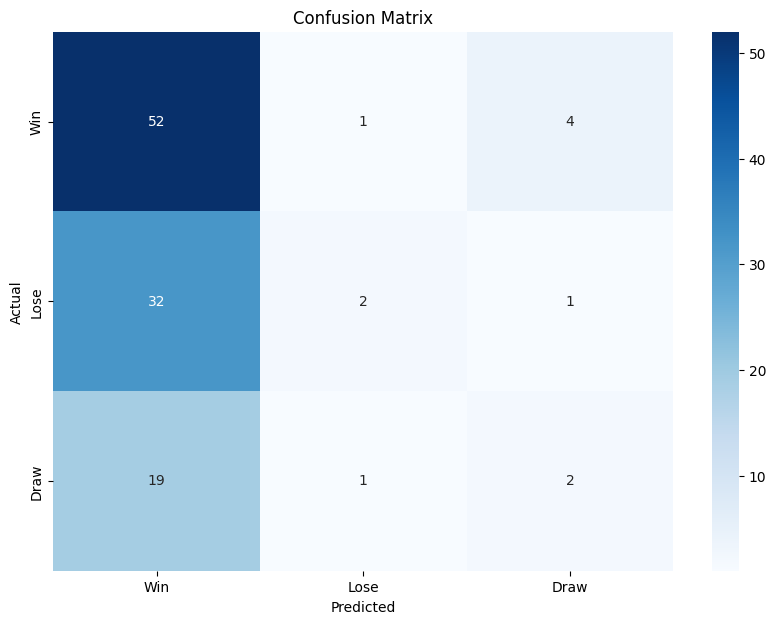

In [111]:
# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]
cm = cm[desired_indices][:, desired_indices]

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_labels, yticklabels=desired_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [112]:
results_df = pd.DataFrame(test_df["Predicted"] == test_df["result"], columns=["Correct"])

In [113]:
df_results = pd.read_csv('test_results.csv')

mismatched_df = df_results[df_results['result'] != df_results['Predicted']]

display_df = mismatched_df[["opponent", "result", "Predicted"]]

display_df

,opponent,result,Predicted
1,Southampton,D,W
5,Aston Villa,L,W
6,Everton,D,W
7,Leicester City,L,W
8,Liverpool,L,W
10,Manchester City,L,W
11,Watford,L,W
12,Chelsea,D,W
16,Newcastle United,D,W
18,Wolverhampton Wanderers,L,W
